In [1]:
from lifelines import CoxPHFitter

In [2]:
from utils.config import load_datasets, get_generated_gan_train_dataset_indexes, get_test_dataset_indexes
  
                
test_folder = "../outputs/datasets"
test_indexes = get_test_dataset_indexes(test_folder)
test_sets = load_datasets(folder=test_folder, names=test_indexes)

folder = "../outputs/generated_datasets"
dataset_indexes = get_generated_gan_train_dataset_indexes(folder)
datasets = load_datasets(folder=folder, names=dataset_indexes)

Error loading ..\outputs\generated_datasets\acath_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\actg_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\Aids2_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\Bergamaschi_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\breast_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\burn_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\cancer_train_gan.pkl: No module named 'synthcity'
Error loading ..\outputs\generated_datasets\cgd_train_gan.pkl: No module named 'synthcity'


In [3]:
# datasets
# ['colon_train_gan']
# test_sets['colon']
# test_sets['colon_test']
test_sets
# dataset_indexes

{'acath_test':        pid  event  time  num_age  num_choleste fac_sex
 2909  2909      1     0       47           NaN       M
 235    235      1     2       56           NaN       M
 3182  3182      0     3       50         228.0       M
 246    246      0    82       52           NaN       F
 85      85      0   240       65         192.0       M
 ...    ...    ...   ...      ...           ...     ...
 1734  1734      1     6       33         382.0       M
 3264  3264      0     5       49           NaN       F
 2665  2665      1    19       58           NaN       M
 3382  3382      0     0       29           NaN       M
 1460  1460      1    74       48         259.0       M
 
 [1052 rows x 6 columns],
 'actg_test':        pid  event  time  num_karnof  num_cd4  num_priorzdv  num_age   fac_tx  \
 500    500      0   319          90     52.5           6.0       34      IDV   
 274    274      0   264         100      2.0          29.0       55      IDV   
 860    860      0   292      

In [4]:
from utils.preprocess import get_column_transformer

data_pre = datasets['colon_train_gan'].drop(columns=['pid'], errors='ignore')
data = get_column_transformer(data_pre)


data

C:\Users\johan\anaconda3\envs\reseach_project_models_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ohe__fac_rx_Lev+5FU,ohe__fac_rx_Obs,ohe__fac_sex_M,ohe__fac_differ_moderate,ohe__fac_differ_poor,ohe__fac_differ_well,ohe__fac_obstruct_Y,ohe__fac_perfor_Y,ohe__fac_adhere_Y,ohe__fac_node4_Y,remainder__event,remainder__time,remainder__num_age,remainder__num_nodes
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2743.0,35.902190,2.312872
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1285.0,68.578293,2.215636
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,831.0,37.425712,3.364383
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1071.0,66.083198,20.322912
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2441.0,37.177004,2.211875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2239.0,38.624738,2.270356
4996,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2366.0,40.913679,2.008399
4997,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,515.0,61.560969,14.417927
4998,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1782.0,60.382698,1.499974


In [5]:
from utils.preprocess import impute_missing_values

data_clean = impute_missing_values(data)


In [6]:
train_event_times = data_clean['remainder__time'].values
train_event_indicators = data_clean['remainder__event'].values
test_event_times = test_sets['colon_test']['time'].values
test_event_indicators = test_sets['colon_test']['event'].values

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
# Drop the columns related to duration and event as they should not be included in VIF calculation
X = data_clean.drop(columns=['remainder__time', 'remainder__event'])

# Add a constant term for the intercept
X = add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["Variable Inflation Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                    Variable  Variable Inflation Factor
0                      const                 126.220871
1        ohe__fac_rx_Lev+5FU                   1.682586
2            ohe__fac_rx_Obs                   1.952352
3             ohe__fac_sex_M                   1.319396
4   ohe__fac_differ_moderate                  11.412259
5       ohe__fac_differ_poor                   7.071877
6       ohe__fac_differ_well                   6.152158
7        ohe__fac_obstruct_Y                   1.063208
8          ohe__fac_perfor_Y                   1.056028
9          ohe__fac_adhere_Y                   1.069693
10          ohe__fac_node4_Y                   2.350122
11        remainder__num_age                   1.237507
12      remainder__num_nodes                   2.762839


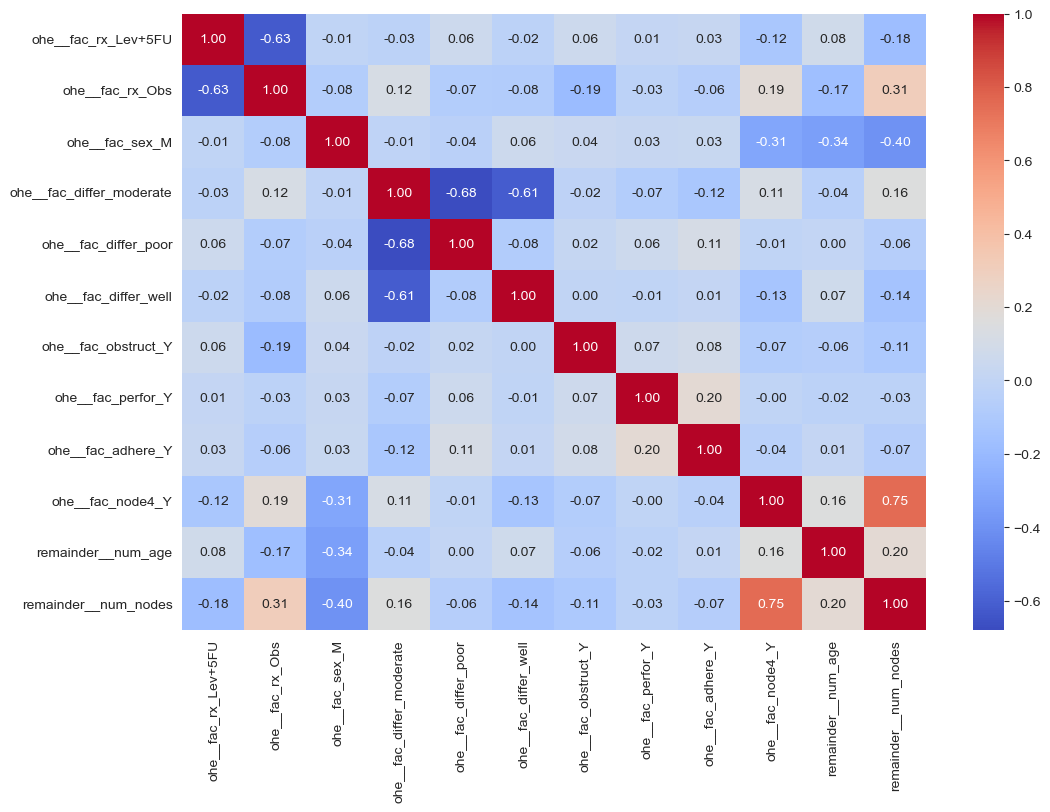

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the columns related to duration and event
corr_matrix = data_clean.drop(columns=['remainder__time', 'remainder__event']).corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


In [9]:
model = CoxPHFitter()
model.fit(data_clean, duration_col='remainder__time', event_col='remainder__event')
model.print_summary()

<lifelines.CoxPHFitter: fitted with 5000 total observations, 2616 right-censored observations>
             duration col = 'remainder__time'
                event col = 'remainder__event'
      baseline estimation = breslow
   number of observations = 5000
number of events observed = 2384
   partial log-likelihood = -18427.49
         time fit was run = 2024-08-11 18:59:25 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
ohe__fac_rx_Lev+5FU      -0.04      0.96      0.06           -0.17            0.08                0.85                1.09
ohe__fac_rx_Obs          -0.07      0.93      0.06           -0.19            0.04                0.83                1.05
ohe__fac_sex_M           -0.52      0.59      0.05           -0.62           -0.43                0.54                0.65
ohe__fac_differ_moderate -0.92      0.40      0.16           -1.23           -0.61                0.29                0.54
ohe__fac_differ_poor     -0.71      0.49      0.17           -1.05           -0.38                0.35                0.69
ohe__fac_differ_well     -0.41      0.67      0.18           -0.75           -0.06                0.47                0.94
ohe__fac_obstruct_Y       0.63      1.87      0.06            0.52            0.74                1.67                2.10
ohe__fac_perfor_Y         0.52      1.69      0.12            0.29            0.76                1.33                2.15
ohe__fac_adhere_Y         0.67      1.96      0.06            0.55            0.80                1.73                2.22
ohe__fac_node4_Y          0.82      2.28      0.06            0.70            0.95                2.02                2.57
remainder__num_age        0.01      1.01      0.00            0.00            0.01                1.00                1.01
remainder__num_nodes      0.08      1.08      0.00            0.07            0.09                1.07                1.09

                          cmp to      z      p  -log2(p)
covariate                                               
ohe__fac_rx_Lev+5FU         0.00  -0.65   0.51      0.96
ohe__fac_rx_Obs             0.00  -1.21   0.23      2.14
ohe__fac_sex_M              0.00 -10.79 <0.005     87.70
ohe__fac_differ_moderate    0.00  -5.82 <0.005     27.34
ohe__fac_differ_poor        0.00  -4.18 <0.005     15.04
ohe__fac_differ_well        0.00  -2.31   0.02      5.58
ohe__fac_obstruct_Y         0.00  10.95 <0.005     90.22
ohe__fac_perfor_Y           0.00   4.29 <0.005     15.79
ohe__fac_adhere_Y           0.00  10.64 <0.005     85.38
ohe__fac_node4_Y            0.00  13.41 <0.005    133.71
remainder__num_age          0.00   2.47   0.01      6.20
remainder__num_nodes        0.00  19.14 <0.005    268.97
---
Concordance = 0.78
Partial AIC = 36878.98
log-likelihood ratio test = 2373.51 on 12 df
-log2(p) of ll-ratio test = inf

In [10]:
cox_survival_function = model.predict_survival_function(data_clean)


In [11]:
model.predict_median(data_clean)


0          inf
1       1288.0
2        759.0
3        597.0
4          inf
         ...  
4995       inf
4996       inf
4997     681.0
4998       inf
4999       inf
Name: 0.5, Length: 5000, dtype: float64

In [12]:
model.predict_partial_hazard(data_clean)

0       0.305324
1       1.192095
2       2.583293
3       5.588268
4       0.304987
          ...   
4995    0.308736
4996    0.306197
4997    3.446041
4998    1.061722
4999    0.305061
Length: 5000, dtype: float64

<Axes: >

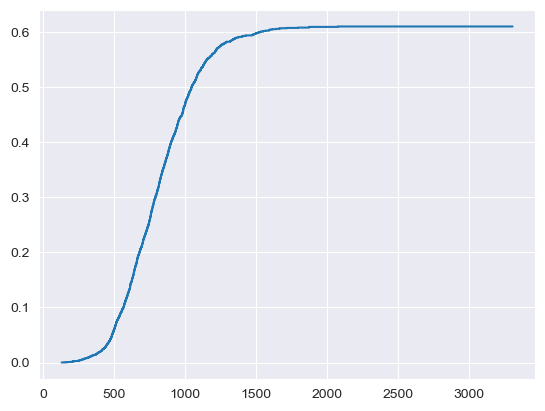

In [13]:
model.baseline_cumulative_hazard_["baseline cumulative hazard"].plot(drawstyle="steps-post", label="semi")

In [14]:
model.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

KeyError: 'covariate `prio` is not present in the original dataset'

In [15]:
model.check_assumptions(data_clean)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 5000 total observations, 2616 right-censored observations>
         test_name = proportional_hazard_test

---
                               test_statistic      p  -log2(p)
ohe__fac_adhere_Y        km             13.82 <0.005     12.28
                         rank           13.83 <0.005     12.29
ohe__fac_differ_moderate km              0.62   0.43      1.21
                         rank            0.62   0.43      1.21
ohe__fac_differ_poor     km             34.19 <0.005     27.58
                         rank           34.17 <0.005     27.56
ohe__fac_differ_well     km              2.48   0.12      3.11
                         rank            2.47   0.12      3.10
ohe__fac_node4_Y         km             23.13 <0.005     19.33
                         rank           23.10 <0.005     19.31
ohe__fac_obstruct_Y      km             13.71 <0.005     12.20
                         rank           13.68 <0.005     12.17
ohe__fac_perfor_Y        km              0.72   0.40      1.33
                         rank            0.72   0.40      1.33
ohe__fac_rx_Lev+5FU      km              3.27   0.07      3.82
                         rank            3.25   0.07      3.81
ohe__fac_rx_Obs          km              1.08   0.30      1.74
                         rank            1.09   0.30      1.75
ohe__fac_sex_M           km              9.56 <0.005      8.97
                         rank            9.51 <0.005      8.93
remainder__num_age       km              2.33   0.13      2.98
                         rank            2.33   0.13      2.98
remainder__num_nodes     km              9.73 <0.005      9.11
                         rank            9.70 <0.005      9.08



1. Variable 'ohe__fac_sex_M' failed the non-proportional test: p-value is 0.0020.

   Advice: with so few unique values (only 2), you can include `strata=['ohe__fac_sex_M', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'ohe__fac_differ_poor' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['ohe__fac_differ_poor',
...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'ohe__fac_obstruct_Y' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['ohe__fac_obstruct_Y', ...]`
in the call in `.fit`. See documentation in link [E] below.

4. Variable 'ohe__fac_adhere_Y' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['ohe__fac_adhere_Y', ...]`
in the call in `.fit`. See documentation in link [E] below.

5. Variabl

[]

In [16]:
from sksurv.ensemble import RandomSurvivalForest
import numpy as np

event = data_clean['remainder__event'].values.astype(bool)
time = data_clean['remainder__time'].values

# Create a 2D object array to preserve the boolean type
y = np.array(list(zip(event, time)), dtype=[('event', 'bool'), ('time', 'float')])



rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=20
)
rsf.fit(X=data_clean, y=y)


RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [17]:
test_pre = test_sets['colon_test'].drop(columns=['pid'], errors='ignore')
test = get_column_transformer(test_pre)
test_X = impute_missing_values(test)
# test_x = test.drop(["event", "time"], axis=1)
# test


rsf_survival_function = rsf.predict_survival_function(test_X)
rsf_survival_function

C:\Users\johan\anaconda3\envs\reseach_project_models_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([StepFunction(x=array([ 132.,  149.,  153., ..., 3288., 3298., 3304.]), y=array([0.99996101, 0.99991395, 0.99991395, ..., 0.1032951 , 0.1032951 ,
              0.1032951 ]), a=1.0, b=0.0)                                                                                                              ,
       StepFunction(x=array([ 132.,  149.,  153., ..., 3288., 3298., 3304.]), y=array([1.        , 1.        , 0.99928518, ..., 0.09088799, 0.09088799,
              0.09088799]), a=1.0, b=0.0)                                                                                                              ,
       StepFunction(x=array([ 132.,  149.,  153., ..., 3288., 3298., 3304.]), y=array([1.        , 0.99996667, 0.99996667, ..., 0.96974879, 0.96974879,
              0.96974879]), a=1.0, b=0.0)                                                                                                              ,
       StepFunction(x=array([ 132.,  149.,  153., ..., 3288., 3298., 3304.]), y=array

In [18]:
from SurvivalEVAL.Evaluator import  ScikitSurvivalEvaluator, LifelinesEvaluator

cox_model_evals = LifelinesEvaluator(cox_survival_function, train_event_times, train_event_indicators, test_event_times, test_event_indicators)
rsf_model_evals = ScikitSurvivalEvaluator(rsf_survival_function, train_event_times, train_event_indicators, test_event_times, test_event_indicators)

C:\Users\johan\anaconda3\envs\reseach_project_models_env\Lib\site-packages\SurvivalEVAL\Evaluator.py:60: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. A authentic survival curve should start from 0 "


In [19]:
cox_model_evals.concordance()

(0.7771290271217495, 7047693.0, 9068884.0)